In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [261]:
#read csv file into Pandas DataFrame
df = pd.read_csv('data/diabetic_data.csv')

In [262]:
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Data Overview

Column Names

In [304]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [264]:
df.describe()
## This is not very useful as most of these numerical values are categorical variables

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [265]:
#replace ? in df with np.nan and count values

df = df.replace('?',np.nan)
df.count()


encounter_id                101766
patient_nbr                 101766
race                         99493
gender                      101766
age                         101766
weight                        3197
admission_type_id           101766
discharge_disposition_id    101766
admission_source_id         101766
time_in_hospital            101766
payer_code                   61510
medical_specialty            51817
num_lab_procedures          101766
num_procedures              101766
num_medications             101766
number_outpatient           101766
number_emergency            101766
number_inpatient            101766
diag_1                      101745
diag_2                      101408
diag_3                      100343
number_diagnoses            101766
max_glu_serum               101766
A1Cresult                   101766
metformin                   101766
repaglinide                 101766
nateglinide                 101766
chlorpropamide              101766
glimepiride         

There will be several disposition IDs that will not be considered in calculations as they describe a patient that has expired or was terminally ill and discharged to a hospice care facility. As can be seen by the difference in the count column, this accounted for about 

In [279]:

print('Removing patients with below discharge IDs accounted for a '+str((101766-95652)/101766 * 100)+'% loss of data')

Removing patients with below discharge IDs accounted for a 6.0079004775661815% loss of data


In [276]:
df = df[~df.discharge_disposition_id.isin([11,13,14,18,19,20,21])]
df.count()


encounter_id                95652
patient_nbr                 95652
race                        93436
gender                      95652
age                         95652
weight                       3093
admission_type_id           95652
discharge_disposition_id    95652
admission_source_id         95652
time_in_hospital            95652
payer_code                  59922
medical_specialty           49827
num_lab_procedures          95652
num_procedures              95652
num_medications             95652
number_outpatient           95652
number_emergency            95652
number_inpatient            95652
diag_1                      95633
diag_2                      95303
diag_3                      94281
number_diagnoses            95652
max_glu_serum               95652
A1Cresult                   95652
metformin                   95652
repaglinide                 95652
nateglinide                 95652
chlorpropamide              95652
glimepiride                 95652
acetohexamide 

Below is a group by of the 'readmitted' column as well as the 'discharge_disposition_id' column. 

**Readmitted**: 

There are three possible values here:<br>
- Readmitted in less than 30 days.<br>
- Readmitted in greater than 30 days.<br>
- No readmission. <br>

A patient being readmitted in less than 30 days is a key metric being tracked by the Hospital Readmission Reduction Program (HRRP). If Hospital readmissions are found to be above average for any given Hospital, the HRRP will reduce reimbursements to those hospitals. 

In [280]:
# finding frequency of patients readmitted in less than 30 days. 

df1 = pd.DataFrame(df.groupby(df.readmitted).size())
df1 = df1.reset_index()
df1.columns = ['readmitted', 'frequency']
df1

,readmitted,frequency
0,<30,10855
1,>30,34475
2,NO,50322


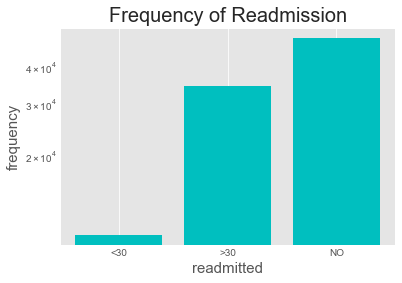

In [281]:
#visualizing frequency of patients admitted

plt.bar(np.array(df1.readmitted),np.array(df1.frequency),color='c')
plt.xlabel('readmitted', fontsize=15)
plt.ylabel('frequency', fontsize=15)
plt.xticks(np.array(df1.readmitted),fontsize=10)
plt.title('Frequency of Readmission', fontsize=20)
plt.yscale('log')
plt.show()


#### Readmission Breakdown by Demographics

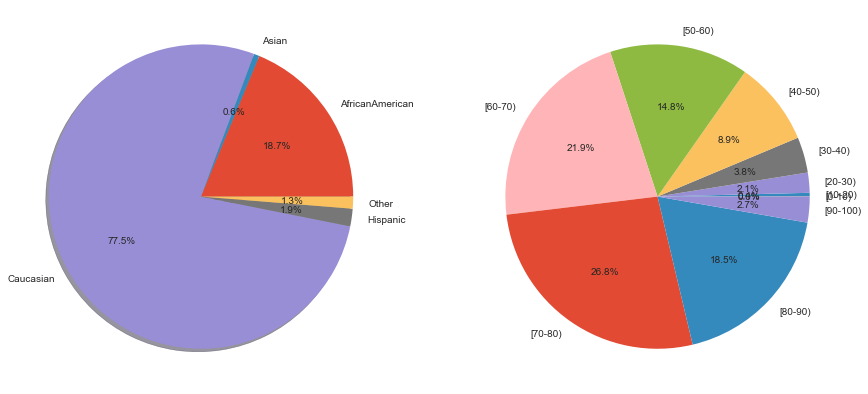

In [282]:
#Get breakdowns of various dempgraphics. First create a mask to filter for 
#patients that were readmitted in fewer than 30 days.
mask = df['readmitted'] == '<30' 
readmitsdf = df[mask]


readmitrace = pd.DataFrame(readmitsdf.groupby(readmitsdf.race).size())
readmitrace = readmitrace.reset_index()
readmitrace.columns = ['race','count']
readmitrace['percent'] = readmitrace['count'] / sum(readmitrace['count'])

readmitage = pd.DataFrame(readmitsdf.groupby(readmitsdf.age).size())
readmitage = readmitage.reset_index()
readmitage.columns = ['age', 'count']
readmitage['percent'] = readmitage['count'] / sum(readmitage['count'])
# age = pd.DataFrame(df.groupby(df.age).size())
# gender = pd.DataFrame(df.groupby(df.gender).size())
# weight = pd.DataFrame(df.groupby(df.weight).size())

fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].pie(readmitrace['percent'], labels=readmitrace['race'], autopct='%1.1f%%', shadow=True)
ax[0].set_title = 'Readmission by Race'


ax[1].pie(readmitage['percent'], labels=readmitage['age'], autopct='%1.1f%%', shadow=False)
plt.tight_layout
ax[1].set_title = 'Readmission by Age'




No handles with labels found to put in legend.
No handles with labels found to put in legend.


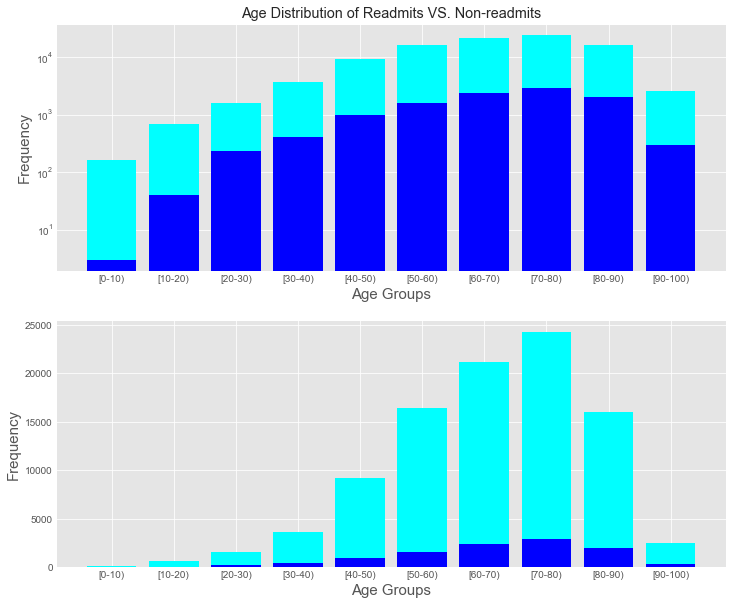

In [294]:
readmitsagedf = pd.DataFrame(readmitsdf.groupby(readmitsdf.age).size())
readmitsagedf = readmitsagedf.reset_index()
readmitsagedf.columns = ['age group', 'freq']

agedf = pd.DataFrame(df.groupby(df.age).size())
agedf = agedf.reset_index()
agedf.columns = ['age group', 'freq']

readmitsagedf.freq

fig,ax = plt.subplots(2,1, figsize=(12,10))
ax[0].bar(agedf['age group'], agedf.freq, color='cyan')
ax[0].bar(readmitsagedf['age group'], readmitsagedf.freq, color='blue')
ax[0].set_ylabel('Frequency',fontsize=15)
ax[0].set_xlabel('Age Groups', fontsize=15)
ax[0].set_title('Age Distribution of Readmits VS. Non-readmits')
ax[0].set_xticks(range(len(agedf)))
ax[0].set_xticklabels(agedf['age group'])
ax[0].set_yscale('log')
ax[0].legend()

ax[1].bar(agedf['age group'], agedf.freq, color='cyan')
ax[1].bar(readmitsagedf['age group'], readmitsagedf.freq, color='blue')
ax[1].set_ylabel('Frequency',fontsize=15)
ax[1].set_xlabel('Age Groups', fontsize=15)
ax[1].set_xticks(range(len(agedf)))
ax[1].set_xticklabels(agedf['age group'])
ax[1].legend()




**Discharge Disposition ID**<br>
There were 28 different discharge disposition IDs. Some of these can already be eliminated from consideration. 


In [284]:
discharge_dispo = pd.DataFrame(df.groupby(df.discharge_disposition_id).size())
discharge_dispo = discharge_dispo.reset_index()
discharge_dispo.columns = ['dispoID','frequency']
discharge_dispo['dispolabel'] = df_dc_dispo_id.description
discharge_dispo = discharge_dispo[~discharge_dispo.dispoID.isin([11,13,14,18,19,20,21])]
# removed the above mentioned dispoIDs as they will not be factored in any calculations. 
# will also remove any records with this dispoID from the dataset 
discharge_dispo
# discharge_dispo.replace('','test')





,dispoID,frequency,dispolabel
0,1,60234,Discharged to home
1,2,2128,Discharged/transferred to another short term h...
2,3,13954,Discharged/transferred to SNF
3,4,815,Discharged/transferred to ICF
4,5,1184,Discharged/transferred to another type of inpa...
5,6,12902,Discharged/transferred to home with home healt...
6,7,623,Left AMA
7,8,108,Discharged/transferred to home under care of H...
8,9,21,Admitted as an inpatient to this hospital
9,10,6,Neonate discharged to another hospital for neo...


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

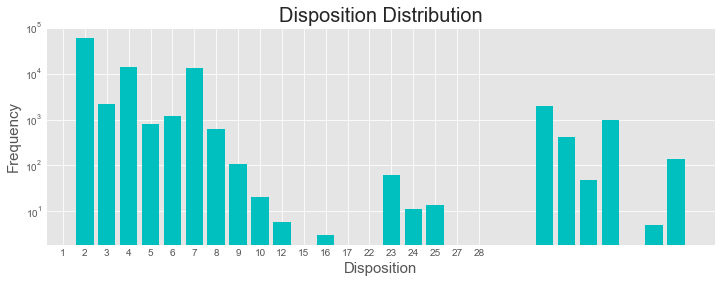

In [287]:
fig,ax = plt.subplots(1,figsize=(12,4))
ax.bar(discharge_dispo['dispoID'], discharge_dispo.frequency,color='c')
ax.set_ylabel('Frequency',fontsize=15)
ax.set_xlabel('Disposition',fontsize=15)
ax.set_title('Disposition Distribution',fontsize=20)
ax.set_xticks(range(len(discharge_dispo)))
ax.set_xticklabels(discharge_dispo.dispoID)
ax.set_yscale('log')
plt.tight_layout

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [13]:
dfid = pd.read_csv('data/IDs_mapping.csv')
# dfid

In [14]:
df_admission_type_id = dfid[0:8]
df_admission_type_id

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [240]:
df_dc_dispo_id = dfid[9:40]
df_dc_dispo_id.columns=['discharge_disposition_id', 'description']
df_dc_dispo_id = df_dc_dispo_id.drop(index=9)
df_dc_dispo_id = df_dc_dispo_id.reset_index()

df_dc_dispo_id
# df_dc_dispo_id.reset_index(drop=True)



,index,discharge_disposition_id,description
0,10,1,Discharged to home
1,11,2,Discharged/transferred to another short term h...
2,12,3,Discharged/transferred to SNF
3,13,4,Discharged/transferred to ICF
4,14,5,Discharged/transferred to another type of inpa...
5,15,6,Discharged/transferred to home with home healt...
6,16,7,Left AMA
7,17,8,Discharged/transferred to home under care of H...
8,18,9,Admitted as an inpatient to this hospital
9,19,10,Neonate discharged to another hospital for neo...


In [166]:
df_admission_source_id = dfid[41:]
df_admission_source_id.columns=['admission_source_id','description']
df_admission_source_id.groupby(df_admission_source_id.admission_source_id).count()
df_admission_source_id
# df_admission_source_id.drop(index=41)

,admission_source_id,description
41,admission_source_id,description
42,1,Physician Referral
43,2,Clinic Referral
44,3,HMO Referral
45,4,Transfer from a hospital
46,5,Transfer from a Skilled Nursing Facility (SNF)
47,6,Transfer from another health care facility
48,7,Emergency Room
49,8,Court/Law Enforcement
50,9,Not Available


In [90]:
df[list(df.columns)[:10]].head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12


In [142]:
df[list(df.columns)[10:20]].head(10)

,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2
0,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN
1,NaN,NaN,59,0,18,0,0,0,276,250.01
2,NaN,NaN,11,5,13,2,0,1,648,250
3,NaN,NaN,44,1,16,0,0,0,8,250.43
4,NaN,NaN,51,0,8,0,0,0,197,157
5,NaN,NaN,31,6,16,0,0,0,414,411
6,NaN,NaN,70,1,21,0,0,0,414,411
7,NaN,NaN,73,0,12,0,0,0,428,492
8,NaN,NaN,68,2,28,0,0,0,398,427
9,NaN,InternalMedicine,33,3,18,0,0,0,434,198


In [143]:
df[list(df.columns)[20:30]].head(10)

,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide
0,NaN,1,None,None,No,No,No,No,No,No
1,255,9,None,None,No,No,No,No,No,No
2,V27,6,None,None,No,No,No,No,No,No
3,403,7,None,None,No,No,No,No,No,No
4,250,5,None,None,No,No,No,No,No,No
5,250,9,None,None,No,No,No,No,No,No
6,V45,7,None,None,Steady,No,No,No,Steady,No
7,250,8,None,None,No,No,No,No,No,No
8,38,8,None,None,No,No,No,No,No,No
9,486,8,None,None,No,No,No,No,No,No


In [92]:
df[list(df.columns)[30:40]].head(10)

,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide
0,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No
2,Steady,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No
4,Steady,No,No,No,No,No,No,No,No,No
5,No,No,No,No,No,No,No,No,No,No
6,No,No,No,No,No,No,No,No,No,No
7,No,Steady,No,No,No,No,No,No,No,No
8,Steady,No,No,No,No,No,No,No,No,No
9,No,No,No,No,Steady,No,No,No,No,No


In [93]:
df[list(df.columns)[40:50]].head(10)

,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,No,No,No,No,No,No,No,No,No,NO
1,No,Up,No,No,No,No,No,Ch,Yes,>30
2,No,No,No,No,No,No,No,No,Yes,NO
3,No,Up,No,No,No,No,No,Ch,Yes,NO
4,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,No,Steady,No,No,No,No,No,No,Yes,>30
6,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,No,No,No,No,No,No,No,No,Yes,>30
8,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [296]:
import researchpy as rp
from scipy import stats


In [301]:
crosstab = pd.crosstab(df['race'],df['readmitted'])
crosstab

readmitted,<30,>30,NO
race,,,
AfricanAmerican,2000,6255,9558
Asian,63,160,392
Caucasian,8272,26504,36924
Hispanic,198,588,1105
Other,136,430,851


In [300]:
stats.chi2_contingency(crosstab)


(129.65966636148028,
 3.327988278072635e-24,
 8,
 array([[ 2033.97937626,  6469.88078471,  9309.13983903],
        [   70.22384306,   223.37487692,   321.40128002],
        [ 8187.07243461, 26042.24174836, 37470.68581703],
        [  215.92404427,   686.83234513,   988.2436106 ],
        [  161.80030181,   514.67024487,   740.52945332]]))

In [302]:
table, results = rp.crosstab(df['race'],df['readmitted'],prop='col', test='chi-square')
table

readmitted                        
                       <30     >30      NO     All
race                                              
AfricanAmerican      18.75   18.43   19.57   19.06
Asian                 0.59    0.47    0.80    0.66
Caucasian            77.53   78.10   75.62   76.74
Hispanic              1.86    1.73    2.26    2.02
Other                 1.27    1.27    1.74    1.52
All                 100.00  100.00  100.00  100.00

In [303]:
results

,Chi-square test,results
0,Pearson Chi-square ( 8.0) =,129.6597
1,p-value =,0.0000
2,Cramer's V =,0.0263


In [297]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2216
gender                          0
age                             0
weight                      92559
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  35730
medical_specialty           45825
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         19
diag_2                        349
diag_3                       1371
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 